In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding, Isomap
# sns.set_theme()
import GPy

import imp

from ikd import utils, core, evaluate, datasets
imp.reload(utils)
imp.reload(core)
imp.reload(evaluate)
imp.reload(datasets)

<module 'ikd.datasets' from '/storage/coda1/p-awu36/0/cli726/ikd/ikd/ikd/datasets.py'>

In [2]:
df_list = []
for dataset in range(3):
    for kernel in ("squared exponential", "rational quadratic", "gamma-exponential", "matern"):
        for n_samples in (100, 200, 500, 1000, 2000, 5000, 10000):
            for method in ('PCA', 'GPLVM', 'IKD'):
                df_list.append(pd.read_csv(f'outputs/{dataset}_{kernel}_{n_samples}_{method}.csv', index_col=0))
df = pd.concat(df_list, ignore_index=True)
df.d_observation = df.d_observation.astype(str)
df['dataset'] = df['dataset'].replace([0, 1, 2], ['Hard', 'Medium', 'Easy'])
df['kernel'] = df['kernel'].replace(['gamma-exponential', 'matern'], ['$\\gamma$-exponential', 'Matérn'])

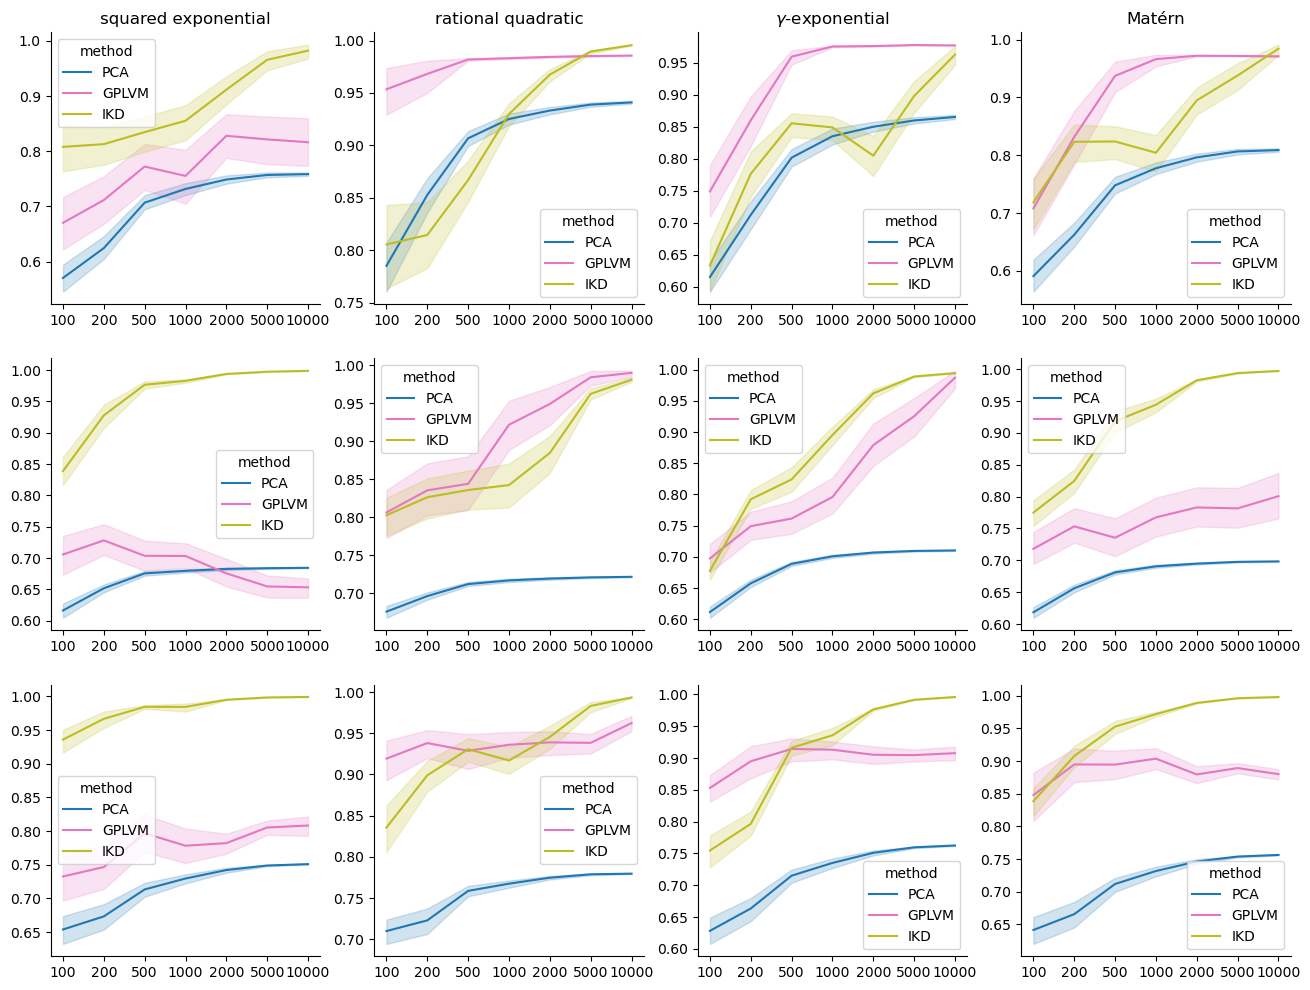

In [3]:
dataset_list = df.dataset.unique()
kernel_list = df.kernel.unique()
fig, axs = plt.subplots(3, 4, figsize=(16, 12))
for i in range(3):
    for j in range(4):
        ax = sns.lineplot(x='d_observation', y='r2_true', hue='method', data=df[np.bitwise_and((df.dataset == dataset_list[i]).values, (df.kernel == kernel_list[j]).values)], palette=['C0', 'C6', 'C8'], ax=axs[i, j])
        ax.set(xlabel=None, ylabel=None)
        if i == 0:
            ax.set_title(kernel_list[j])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

In [4]:
d_latent = 3 # latent dimensionality
dataset = 1
n_points = 100 # number of observations T
d_observation = 1000 # observation dimensionality
kernel = ["squared exponential", "rational quadratic", "gamma-exponential", "matern"][0]
extra_kernel_hyperparam = [None, 1, 1, 3/2][0]
variance = 1
length_scale = 0.5

z_true = datasets.generate_latent(d_latent, dataset, n_points=n_points, show=False)
cov_true = utils.kernel_cov_generator(z_true, kernel=kernel, variance=variance, length_scale=length_scale, extra_kernel_hyperparam=extra_kernel_hyperparam) # K, true kernel covariance matrix

In [7]:
utils.kernel_cov_generator(z_true, length_scale=3)

array([[1.        , 0.99226863, 0.96561948, ..., 0.92134249, 0.88541821,
        0.83902239],
       [0.99226863, 1.        , 0.99012888, ..., 0.94271322, 0.92049338,
        0.88541821],
       [0.96561948, 0.99012888, 1.        , ..., 0.94980796, 0.94271322,
        0.92134249],
       ...,
       [0.92134249, 0.94271322, 0.94980796, ..., 1.        , 0.99012888,
        0.96561948],
       [0.88541821, 0.92049338, 0.94271322, ..., 0.99012888, 1.        ,
        0.99226863],
       [0.83902239, 0.88541821, 0.92134249, ..., 0.96561948, 0.99226863,
        1.        ]])

Clique threshold: 0.1, number of cliques: 230


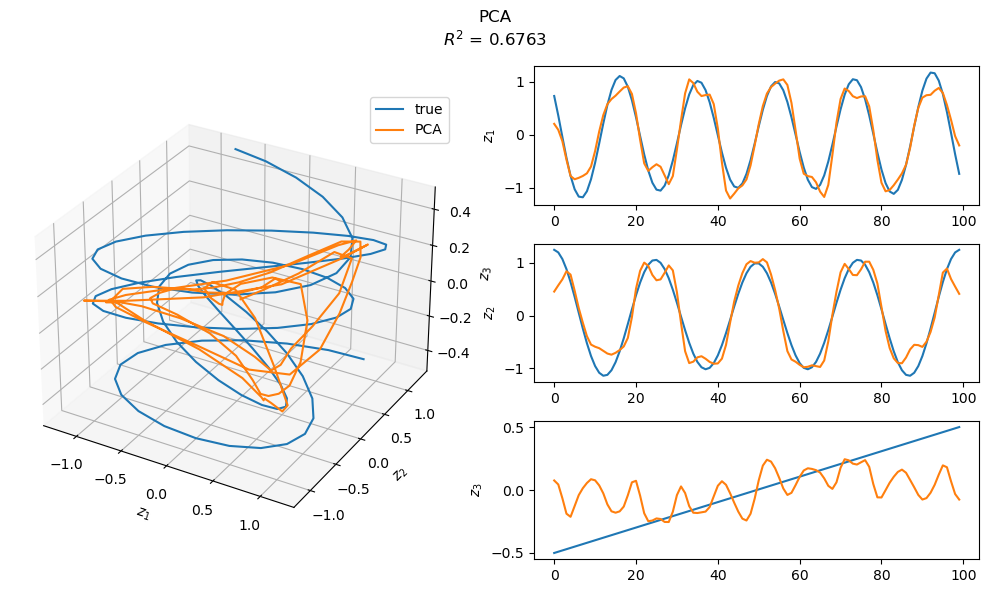

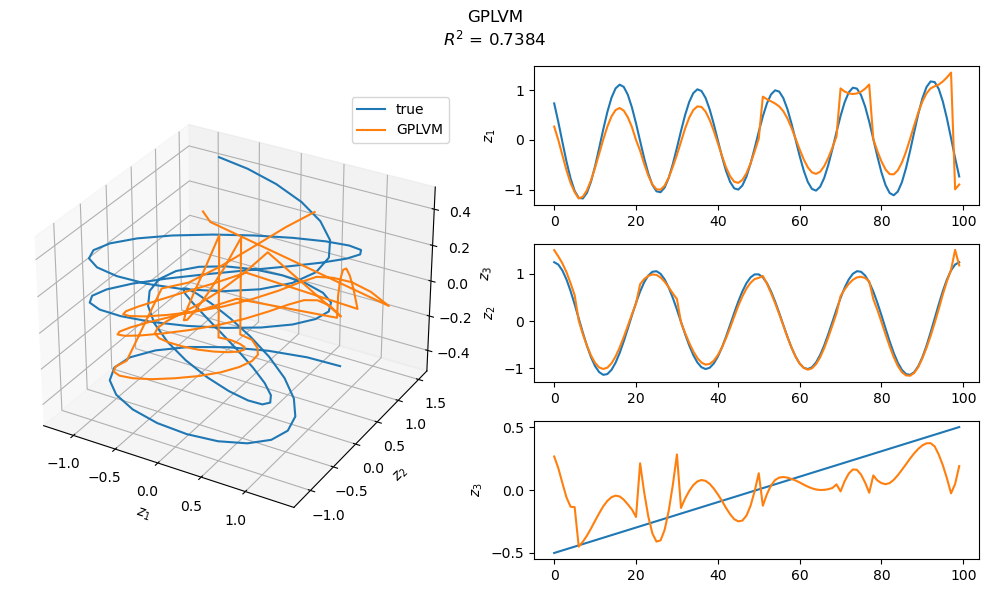

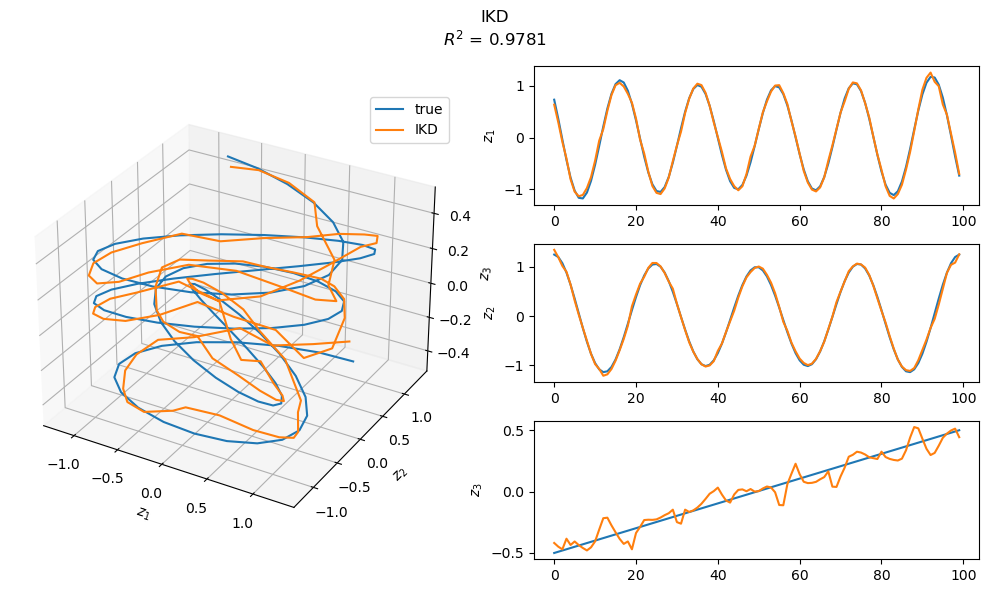

In [8]:
seed = 42
x = datasets.gaussian_process_generator(cov_true, d_observation, seed)
# cov_samp_th = utils.filt_cov_samp(np.cov(x), variance=variance)
# plt.matshow(cov_samp_th)

z_pca = PCA(n_components=d_latent).fit_transform(x)
z_pca_aligned = utils.align(z_true, z_pca)

m_gplvm = GPy.models.GPLVM(x, d_latent, kernel=GPy.kern.RBF(d_latent, variance=1, lengthscale=1))
m_gplvm.likelihood.variance = 1.
m_gplvm.optimize(max_iters=1e4)
z_gplvm = m_gplvm.X.values
z_gplvm_aligned = utils.align(z_true, z_gplvm)

z_isomap = Isomap(n_components=d_latent).fit_transform(x)
z_ikd = core.ikd_blockwise(x, d_latent, kernel=kernel, extra_kernel_hyperparam=extra_kernel_hyperparam, z_ref=z_isomap)
z_ikd_aligned = utils.align(z_true, z_ikd)

evaluate.compare_latents(z_true, z_pca_aligned, 'PCA')
evaluate.compare_latents(z_true, z_gplvm_aligned, 'GPLVM')
evaluate.compare_latents(z_true, z_ikd_aligned, 'IKD')

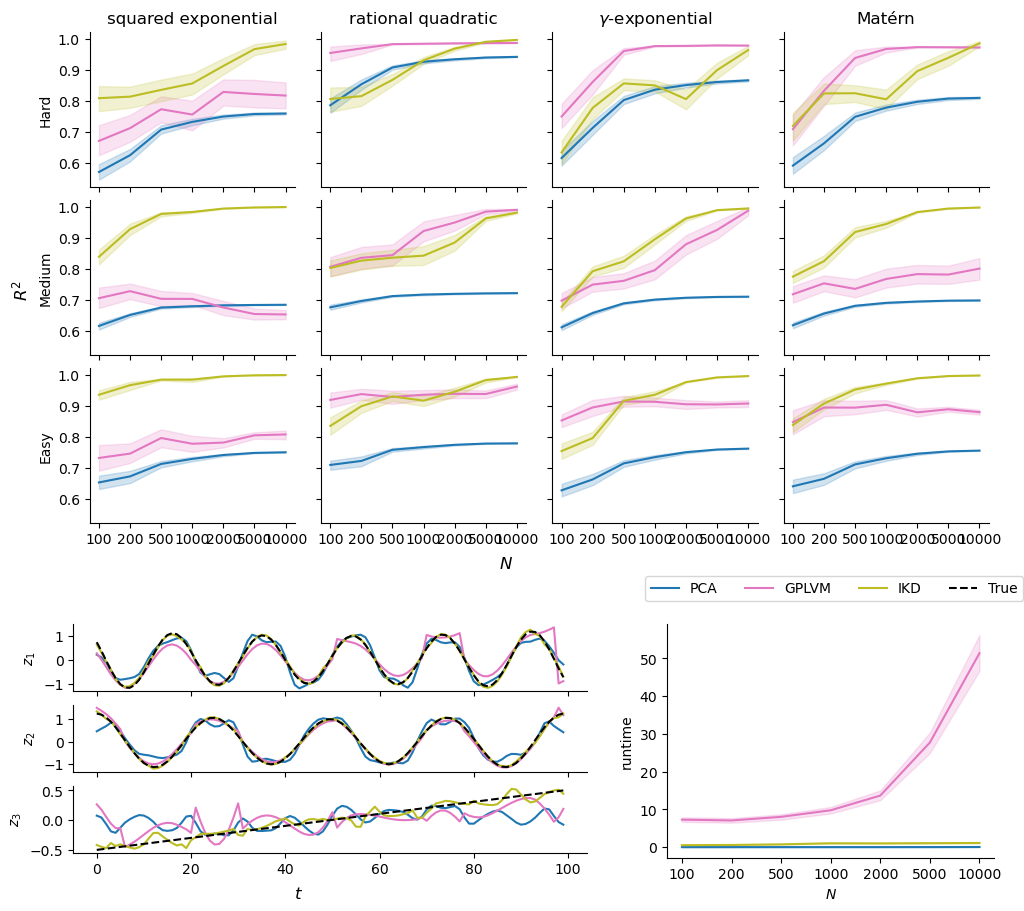

In [11]:
dataset_list = df.dataset.unique()
kernel_list = df.kernel.unique()

d_latent = 3
n_points = 100
kernel = ["squared exponential", "rational quadratic", "gamma-exponential", "matern"]
extra_kernel_hyperparam = [None, 1, 1, 3/2]
variance = 1
length_scale = 0.5

fig = plt.figure(figsize=(10, 9), constrained_layout=True)
subfigs = fig.subfigures(2, 1, height_ratios=[2, 1], hspace=0.1)

axs = subfigs[0].subplots(3, 4, sharex=True, sharey=True)
for i in range(3):
    for j in range(4):
        ax = sns.lineplot(x='d_observation', y='r2_true', hue='method', data=df[np.bitwise_and((df.dataset == dataset_list[i]).values, (df.kernel == kernel_list[j]).values)], palette=['C0', 'C6', 'C8'], ax=axs[i, j], legend=False)
        ax.set(xlabel=None, ylabel=None)
        if i == 0:
            ax.set_title(kernel_list[j])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    axs[i, 0].set_ylabel(['Hard', 'Medium', 'Easy'][i])
subfigs[0].supxlabel('$N$')
subfigs[0].supylabel('$R^2$')

subsubfigs = subfigs[1].subfigures(1, 2, width_ratios=[3, 2], wspace=0.05)
axs = subsubfigs[0].subplots(3, 1, sharex=True)
for i in range(3):
    axs[i].plot(z_pca_aligned[:, i], label='PCA', c='C0')
    axs[i].plot(z_gplvm_aligned[:, i], label='GPLVM', c='C6')
    axs[i].plot(z_ikd_aligned[:, i], label='IKD', c='C8')
    axs[i].plot(z_true[:, i], 'k--', label='True')
    axs[i].set_ylabel(f'$z_{i+1}$')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
subsubfigs[0].supxlabel('$t$')
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.63, 0.34), ncol=4, fontsize=10, labelspacing=0)

ax = subsubfigs[1].subplots(1, 1)
sns.lineplot(data=df, x='d_observation', y='runtime', hue='method', palette=['C0', 'C6', 'C8'], legend=False)
ax.set(xlabel='$N$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.tight_layout()
plt.savefig('GPLVM.pdf', bbox_inches='tight', transparent=True)

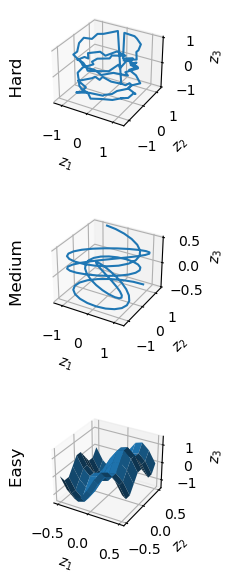

In [47]:
n_points = 100
d_latent = 3
fig, axs = plt.subplots(3, 1, figsize=(2, 6), subplot_kw=dict(projection='3d'), constrained_layout=True)
z_true = datasets.generate_latent(d_latent, 0, n_points=n_points)
axs[0].plot(z_true[:, 0], z_true[:, 1], z_true[:, 2])
axs[0].set_xlabel('$z_1$')
axs[0].set_ylabel('$z_2$')
axs[0].set_zlabel('$z_3$')

z_true = datasets.generate_latent(d_latent, 1, n_points=n_points)
axs[1].plot(z_true[:, 0], z_true[:, 1], z_true[:, 2])
axs[1].set_xlabel('$z_1$')
axs[1].set_ylabel('$z_2$')
axs[1].set_zlabel('$z_3$')

t = np.linspace(-0.5, 0.5, 10)
x, y = np.meshgrid(t, t)
z = np.sin(2 * np.pi * x) + np.cos(3 * np.pi * y) / 2
axs[2].plot_surface(x, y, z)
axs[2].set_xlabel('$z_1$')
axs[2].set_ylabel('$z_2$')
axs[2].set_zlabel('$z_3$')
# plt.tight_layout()
fig.supylabel('Easy                           Medium                           Hard')
fig.savefig('3 3D datasets.pdf', bbox_inches='tight')

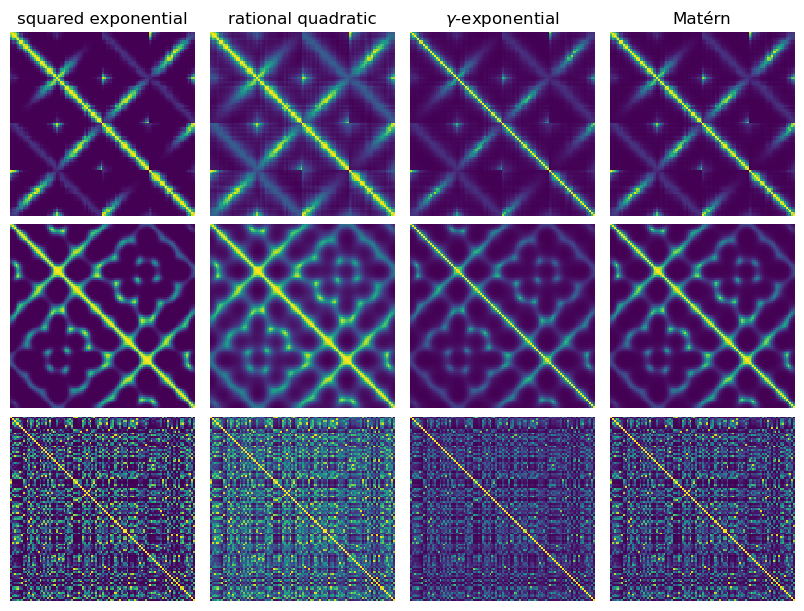

In [48]:
kernel = ["squared exponential", "rational quadratic", "gamma-exponential", "matern"]
extra_kernel_hyperparam = [None, 1, 1, 3/2]
fig, axs = plt.subplots(3, 4, figsize=(8, 6), constrained_layout=True, sharex=True, sharey=True)
for dataset in range(3):
    z_true = datasets.generate_latent(d_latent, dataset, n_points=n_points, show=False)
    for kernel_idx in range(4):
        cov_true = utils.kernel_cov_generator(z_true, kernel=kernel[kernel_idx], variance=1, length_scale=0.5, extra_kernel_hyperparam=extra_kernel_hyperparam[kernel_idx])
        axs[dataset, kernel_idx].matshow(cov_true)
        axs[dataset, kernel_idx].axis('off')
axs[0, 0].set_title('squared exponential')
axs[0, 1].set_title('rational quadratic')
axs[0, 2].set_title('$\\gamma$-exponential')
axs[0, 3].set_title('Matérn')
plt.savefig('true covariance matrix.pdf')